In [1]:
import os
import sys
import pathlib
import subprocess
import glob

root = pathlib.Path("..").resolve()

fortran_source_dir = os.path.join(root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS")
sys.path.append(fortran_source_dir)

reservoir_source_dir = os.path.join(root, "src", "fortran_routing", "mc_pylink_v00", "Reservoir_singleTS")
sys.path.append(reservoir_source_dir)

routing_v02_dir = os.path.join(root, "src", "python_routing_v02","fast_reach")
sys.path.append(routing_v02_dir)

framework_v02_dir = os.path.join(root, "src", "python_framework_v02")
sys.path.append(framework_v02_dir)

framework_v01_dir = os.path.join(root, "src", "python_framework_v01")
sys.path.append(framework_v01_dir)

# scientific packages
import xarray as xr
import pandas as pd
import numpy as np
import netCDF4
from functools import partial
from itertools import chain, islice
import matplotlib.pyplot as plt

# t-route functions
import nhd_network_utilities_v02 as nnu
import nhd_io
import nhd_network
import network_dl

## Compile cython routing module
- This is specific to A. Wlostowski's system.
- TO DO: Revise for Google Colab - see [this notebook](https://github.com/awlostowski-noaa/t-route/blob/network-compute-notebook/notebooks/compute-network-v2.ipynb)

In [2]:
COMPILE_cython = True
if COMPILE_cython:

    # clear .so files as a matter of housekeeping
    subprocess.run(
        [
            "rm", 
            "*.so"
        ],
        cwd=routing_v02_dir,
    )
    
    # compile vaPrecision.f90
    subprocess.run(
        [
            "gfortran", 
            "varPrecision.f90", 
            "-c", 
            "-O0", 
            "-fPIC"],
        cwd=fortran_source_dir,
    )

    # compile MCsingleSegStime_f2py_NOLOOP.f90
    subprocess.run(
        [
            "gfortran",
            "-c",
            "-O0",
            "-fPIC",
            "-o",
            "mc_single_seg.o",
            "MCsingleSegStime_f2py_NOLOOP.f90"
        ],
        cwd=fortran_source_dir,
    )

    # compile pyMCsingleSegStime_NoLoop.f90
    subprocess.run(
        [
            "gfortran",
            "pyMCsingleSegStime_NoLoop.f90",
            "-c",
            "-o",
            "pymc_single_seg.o",
            "-O3",
            "-fPIC"
        ],
        cwd=fortran_source_dir,
    )

    # copy *.o files to python_routing_v02/fast_reach 
    for obj_file in glob.glob(os.path.join(fortran_source_dir, "*.o")):
        print(obj_file)
        subprocess.run(["cp", obj_file, routing_v02_dir])    

    # compile vaPrecision.f90
    subprocess.run(
        [
            "gfortran", 
            "varPrecision.f90", 
            "-c", 
            "-O0", 
            "-fPIC"],
        cwd=reservoir_source_dir,
    )

    # compile module_levelpool.f90
    subprocess.run(
        [
            "gfortran",
            "-c",
            "-O2",
            "-fPIC",
            "-o",
            "module_levelpool.o",
            "module_levelpool.f90"
        ],
        cwd=reservoir_source_dir,
    )

    # compile pymodule_levelpool.f90
    subprocess.run(
        [
            "gfortran",
            "-c",
            "-O2",
            "-fPIC",
            "-o",
            "pymodule_levelpool.o",
            "pymodule_levelpool.f90"
        ],
        cwd=reservoir_source_dir,
    ) 

    # copy *.o files to python_routing_v02/fast_reach 
    for obj_file in glob.glob(os.path.join(reservoir_source_dir, "*.o")):
        print(obj_file)
        subprocess.run(["cp", obj_file, routing_v02_dir])

    numpy_I = "/home/awlostowski/tr/lib/python3.8/site-packages/numpy/core/include"
    py_I = "/usr/include/python3.8"
    py_lib = "/home/awlostowski/tr/lib"

    subprocess.run(
        [
            "cython",
            "-3",
            "-v",
            "-p",
            "--gdb",
            "--line-directives",
            "-Wextra",
            "--cleanup",
            "3",
            "fortran_wrappers.pxd"
            "*.pyx"
        ],
        cwd=routing_v02_dir,
    )

    file = ["fortran_wrappers","mc_reach","reservoir","reach","utils"]
    for f in file:
        subprocess.run(
          [
              "gcc",
              "-pthread",
              "-Wno-unused-result",
              "-Wsign-compare",
              "-DNDEBUG",
              "-fwrapv",
              "-O2",
              "-Wall",
              "-Wstrict-prototypes",
              "-fPIC",
              "-fno-strict-aliasing",
              "-I",
              numpy_I,
              "-I",
              py_I,
              "-mtune=generic",
              "-c",
              "-o",
              f + ".o",
              f + ".c"
          ],
          cwd=routing_v02_dir,
        )

    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-shared", 
            "-L",
            py_lib, 
            "-lgfortran",
            "-o",
            "reach.cpython-38-x86_64-linux-gnu.so",
            "mc_single_seg.o",
            "pymc_single_seg.o",
            "fortran_wrappers.o",
            "reach.o"
        ],
        cwd=routing_v02_dir,
    )

    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-shared", 
            "-L",
            py_lib, 
            "-lgfortran",
            "-o",
            "reservoir.cpython-38-x86_64-linux-gnu.so",
            "module_levelpool.o",
            "pymodule_levelpool.o",
            "fortran_wrappers.o",
            "reservoir.o"
        ],
        cwd=routing_v02_dir,
    )

    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-shared", 
            "-L",
            py_lib, 
            "-o",
            "mc_reach.cpython-38-x86_64-linux-gnu.so",
            "mc_reach.o"
        ],
        cwd=routing_v02_dir,
    )

    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-shared", 
            "-L",
            py_lib, 
            "-o",
            "utils.cpython-38-x86_64-linux-gnu.so",
            "utils.o"
        ],
        cwd=routing_v02_dir,
    ) 
    
import mc_reach

/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/mc_single_seg.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/pymc_single_seg.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/varPrecision.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/var_precision.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/Reservoir_singleTS/module_levelpool.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/Reservoir_singleTS/pymodule_levelpool.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/Reservoir_singleTS/varPrecision.o


## Supernetwork connections for Pocono_TEST2 domain

In [3]:
print("Identifying supernetwork connections set")

test_folder = os.path.join(root, r"test")
geo_input_folder = os.path.join(test_folder, r"input", r"geo")
supernetwork = "Pocono_TEST2"

network_data = nnu.set_supernetwork_data(
    supernetwork=supernetwork, geo_input_folder=geo_input_folder
)

# if the NHDPlus RouteLink file does not exist, download it.
if not os.path.exists(network_data["geo_file_path"]):
    filename = os.path.basename(network_data["geo_file_path"])
    network_dl.download(network_data["geo_file_path"], network_data["data_link"])

# select only the necessary columns of geospatial data, set the DataFrame index
cols = [v for c, v in network_data["columns"].items()]
data = nhd_io.read(network_data["geo_file_path"])
data = data[cols]
data = data.set_index(network_data["columns"]["key"])

# mask NHDNetwork to isolate test network of choice
if "mask_file_path" in network_data:
    data_mask = nhd_io.read_mask(
        network_data["mask_file_path"], layer_string=network_data["mask_layer_string"],
    )
    data = data.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)

# sort index
data = data.sort_index()

# replace downstreams
data = nhd_io.replace_downstreams(data, network_data["columns"]["downstream"], 0)

# extract downstream connections for each node
connections = nhd_network.extract_connections(data, network_data["columns"]["downstream"])

print("supernetwork connections set created.")

Identifying supernetwork connections set
supernetwork connections set created.


## Organize supernetwork into subnetworks and reaches

In [4]:
print("Organizing segments into reaches.")

# reverse the network - track upstream connections
rconn = nhd_network.reverse_network(connections)

# isolate independent subnetworks
subnets = nhd_network.reachable_network(rconn)

# identify the segments in each subnetwork
subreachable = nhd_network.reachable(rconn)

# break each subnetwork into reaches
subreaches = {}
for tw, net in subnets.items():
    path_func = partial(nhd_network.split_at_junction, net)
    subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)

print("Reach creation complete.")

Organizing segments into reaches.
Reach creation complete.


## Load lateral inflow data from WRF-Hydro CHRTOUT files
- CHRTOUT files contain the states and fluxes output from the WRF Hydro model. One such flux term is the magnitude of lateral inflows to each node in the stream network. 
- A python function, `nhd_io.get_ql_from_wrf_hydro`, reads lateral inflow data from CHRTOUT files, provided a list of file paths.
- A single CHRTOUT file is generated for each WRF-simulated timestep. The number of columns in the lateral inflow DataFrame will be equal to the number of file paths handed to `nhd_io.get_ql_from_wrf_hydro` as arguments.

In [5]:
# List of CHRTOUT file paths
path = os.path.join(root, "test","input","geo","NWM_2.1_Sample_Datasets","Pocono_TEST1","example_CHRTOUT")
qlat_files = glob.glob(path + "/*", recursive=True)

ql = nhd_io.get_ql_from_wrf_hydro(qlat_files,index_col="feature_id")

## Load initial conditions from WRF-hydro HYDRO_RST file
- The HYDRO_RST file contains the initial states of the WRF Hydro model. Initial flow and depth conditions are needed to initialize our routing model. 
- A python function, `nhd_io.get_stream_restart_from_wrf_hydro`, reads initial flow and depth states from the HYDRO_RST file. Function inputs are 1) the file path of the HYDRO_RST file, 2) the file path of a "crosswalk" file, and 3) the field name of the index variable in the crosswalk data. 

In [6]:
wrf_hydro_channel_restart_file = os.path.join(root, "test", "input","geo","NWM_2.1_Sample_Datasets","Pocono_TEST1","example_RESTART",
                    "HYDRO_RST.2017-12-31_06-00_DOMAIN1")
wrf_hydro_channel_ID_crosswalk_file = os.path.join(root, "test", "input","geo","NWM_2.1_Sample_Datasets","Pocono_TEST1","primary_domain",
                    "DOMAIN","Route_Link.nc")
wrf_hydro_channel_ID_crosswalk_file_field_name = "link"

q0 = nhd_io.get_stream_restart_from_wrf_hydro(
    wrf_hydro_channel_restart_file,
    wrf_hydro_channel_ID_crosswalk_file,
    wrf_hydro_channel_ID_crosswalk_file_field_name
)

## Set-up routing simulation time domain
- The routing simulation must have a total duration less than of equal to that of the WRF-Hydro simulation. 
- In the cell below, the timestep of the routing simulation is provided and the number of timesteps in the routing model is calculated such that the duration of the routing simulation matches that of the WRT-Hydro simulation.

In [7]:
dt = 5*60  # routing simulation timestep (seconds) 

dt_routing = pd.Timedelta(str(dt) + 'seconds')
wrf_time = ql.columns.astype("datetime64[ns]")
dt_wrf = (wrf_time[1] - wrf_time[0])
sim_duration = (wrf_time[-1] + dt_wrf) - wrf_time[0]

nts = round(sim_duration / dt_routing)


## Execute the routing module

In [14]:
# initialize a results matrix
results = []

# Specify the tailwater of the the test basin
tw = 4186169
reach = subreaches[tw]

# get a list of segments in the subnetwork
r = list(filter(None, chain.from_iterable(reach)))

# add a dt column to the data DataFrame
data["dt"] = dt

# rename columns to specific variable names expected by mc_reach.compute_network
column_rename = {
    network_data["columns"]["dx"]: "dx",
    network_data["columns"]["tw"]: "tw",
    network_data["columns"]["twcc"]: "twcc",
    network_data["columns"]["bw"]: "bw",
    network_data["columns"]["ncc"]: "ncc",
    network_data["columns"]["s0"]: "s0",
    network_data["columns"]["cs"]: "cs",
    network_data["columns"]["n"]: "n",
}

data = data.rename(columns=column_rename)

# change variables to type float32, as expected by mc_reach.compute_network
data = data.astype("float32")

# prep parameter, lateral inflow, and initial condition data to be fed to routing model
data_sub = data.loc[
    r, ["dt", "bw", "tw", "twcc", "dx", "n", "ncc", "cs", "s0"]
].sort_index()

# prep lateral inflow data
qlat_sub = ql.loc[r].sort_index()


# prep initial conditions data
q0_sub = q0.loc[r].sort_index()

# compute the network routing, calculate (flow, depth, and velocity)
results.append(
    mc_reach.compute_network(
        nts,
        reach,
        subnets[tw],
        data_sub.index.values,
        data_sub.columns.values,
        data_sub.values.astype("float32"),
        qlat_sub.values.astype("float32"),
        q0_sub.values.astype("float32"), # !! pass initial conditions, here !!
        True
    )
)

# create a multi-index DataFrame with flow, depth, and velocity simulations
fdv_columns = pd.MultiIndex.from_product([range(nts), ["q", "v", "d"]])
flowveldepth = pd.concat(
    [pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False
)
flowveldepth = flowveldepth.sort_index()

flows = flowveldepth.loc[:, (slice(None), "q")]
flows = flows.T.reset_index(level = [0,1])
flows.rename(columns = {"level_0": "Timestep", "level_1": "Parameter"}, inplace = True)
flows['Time (d)'] = ((flows.Timestep + 1) * dt)/(24*60*60)
flows = flows.set_index('Time (d)')

vel = flowveldepth.loc[:, (slice(None), "v")]
vel = vel.T.reset_index(level = [0,1])
vel.rename(columns = {"level_0": "Timestep", "level_1": "Parameter"}, inplace = True)
vel['Time (d)'] = ((vel.Timestep + 1) * dt)/(24*60*60)
vel = vel.set_index('Time (d)')


In [12]:
# get WRF-simulated flow, velocity and depth
index_col = "feature_id"

li = []
for filename in qlat_files:
    with xr.open_dataset(filename) as ds:
        df1 = ds.to_dataframe()
        
    li.append(df1)

frame = pd.concat(li, axis=0, ignore_index=False)
mod = frame.reset_index()
flow_wrf = mod.pivot(index=index_col, columns="time", values="streamflow")
vel_wrf = mod.pivot(index=index_col, columns="time", values="velocity")

# Compare t-route simulated flow against WRF Hydro simulation

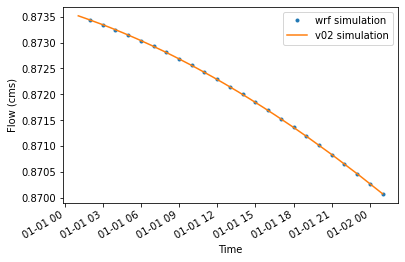

In [15]:
# specify calendar time series' for each simulation
time_routing = pd.period_range((wrf_time[0]-dt_wrf+dt_routing), periods=nts, freq=dt_routing).astype("datetime64[ns]")
time_wrf = flow_wrf.columns.values

# plot t-route and WRF simulated flows
compare_node = tw

plt.plot(time_wrf,flow_wrf.loc[compare_node ,:],'.', label = "wrf simulation")
plt.plot(time_routing,flows.loc[:,compare_node ], '-', label = "v02 simulation")
plt.ylabel("Flow (cms)")
plt.xlabel("Time")
plt.legend()
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.autofmt_xdate()
plt.show()